# Hacker News Upvote Prediction: Enhanced EDA

This notebook explores the Hacker News dataset with both **post-level** and **user-level** features to build a more robust prediction model.

## Approach
1. Load pre-extracted data (items and users)
2. Explore post-level features (title, score, time, etc.)
3. Explore user-level features (karma, account age, etc.)
4. Analyze relationships between user attributes and post scores
5. Identify key features for our prediction model

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# For better visualization
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14})

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print('Libraries imported successfully!')

Libraries imported successfully!


## 1. Load Extracted Data

We'll load the data that was previously extracted from the Hacker News database and stored as parquet files.

In [2]:
# Define paths
ITEMS_PATH = '../data/raw/items_100k.parquet'
USERS_PATH = '../data/raw/users_100k.parquet'
MERGED_PATH = '../data/raw/items_users_merged_100k.parquet'

# Check if the files exist
files_exist = all(os.path.exists(path) for path in [ITEMS_PATH, USERS_PATH, MERGED_PATH])

if files_exist:
    # Load the pre-extracted data
    df_items = pd.read_parquet(ITEMS_PATH)
    df_users = pd.read_parquet(USERS_PATH)
    df_merged = pd.read_parquet(MERGED_PATH)
    print(f"Loaded items: {len(df_items)} rows")
    print(f"Loaded users: {len(df_users)} rows")
    print(f"Loaded merged dataset: {len(df_merged)} rows")
else:
    print("Data files not found. Please run the data extraction script first.")
    print("You can run this from the command line:")
    print("python ../src/utils/data_extraction.py")

Loaded items: 100000 rows
Loaded users: 24474 rows
Loaded merged dataset: 100000 rows


## 2. Explore Post-Level Features

Let's first look at the structure and basic statistics of the items dataset.

In [3]:
# Basic info about the items dataset
print("Items dataset columns:")
print(df_items.columns.tolist())

# Display a few rows
print("\nSample items:")
df_items.head()

Items dataset columns:
['id', 'title', 'score', 'time', 'author', 'url', 'text', 'descendants']

Sample items:


,id,title,score,time,author,url,text,descendants
0,41832458,Monkeys Predict US Elections,1,2024-10-13 23:53:00,giuliomagnifico,https://www.biorxiv.org/content/10.1101/2024.0...,None,0.0
1,41832425,"Scrapling: Fast, Adaptive Web Scraping for Python",1,2024-10-13 23:49:42,d4vinci,https://github.com/D4Vinci/Scrapling,None,1.0
2,41832395,The Greatest Checkmate Ever Given,1,2024-10-13 23:45:21,mellosouls,https://www.youtube.com/watch?v=UULlFap1Zko,None,1.0
3,41832379,PieChartMaster- Unlock your Pie/Rose chart cre...,1,2024-10-13 23:42:21,emperinter,https://apps.apple.com/us/app/piechartmaster-u...,None,0.0
4,41832373,Northeast Blackout of 2003,1,2024-10-13 23:41:46,sandwichsphinx,https://en.wikipedia.org/wiki/Northeast_blacko...,None,0.0


In [4]:
# Summary statistics for items
df_items.describe(include='all')

,id,title,score,time,author,url,text,descendants
count,1.000000e+05,100000,100000.000000,100000,100000,94584,9004,99722.000000
unique,NaN,93904,NaN,NaN,24474,83759,8964,NaN
top,NaN,Hacktoberfest 2024,NaN,NaN,thunderbong,https://github.com/fzliu/radient/blob/main/exa...,"Hey HN!<p>I&#x27;m Gabriel, CEO and co-founder...",NaN
freq,NaN,16,NaN,NaN,1841,17,7,NaN
mean,4.122315e+07,NaN,18.506930,2024-08-11 11:32:36.483319552,NaN,NaN,NaN,9.948086
min,4.061351e+07,NaN,1.000000,2024-06-07 23:11:47,NaN,NaN,NaN,0.000000
25%,4.092555e+07,NaN,1.000000,2024-07-10 11:39:09.249999872,NaN,NaN,NaN,0.000000
50%,4.122284e+07,NaN,2.000000,2024-08-12 11:00:32,NaN,NaN,NaN,0.000000
75%,4.152039e+07,NaN,5.000000,2024-09-12 14:00:00.750000128,NaN,NaN,NaN,2.000000
max,4.183246e+07,NaN,4489.000000,2024-10-13 23:53:00,NaN,NaN,NaN,3859.000000


In [5]:
# Check for missing values
missing_counts = df_items.isnull().sum()
missing_percent = (missing_counts / len(df_items)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percent': missing_percent
})

print("Missing values in items dataset:")
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

Missing values in items dataset:


,Missing Count,Missing Percent
text,90996,90.996
url,5416,5.416
descendants,278,0.278


### Analyze Score Distribution

Let's examine the distribution of scores (upvotes) which is our target variable.

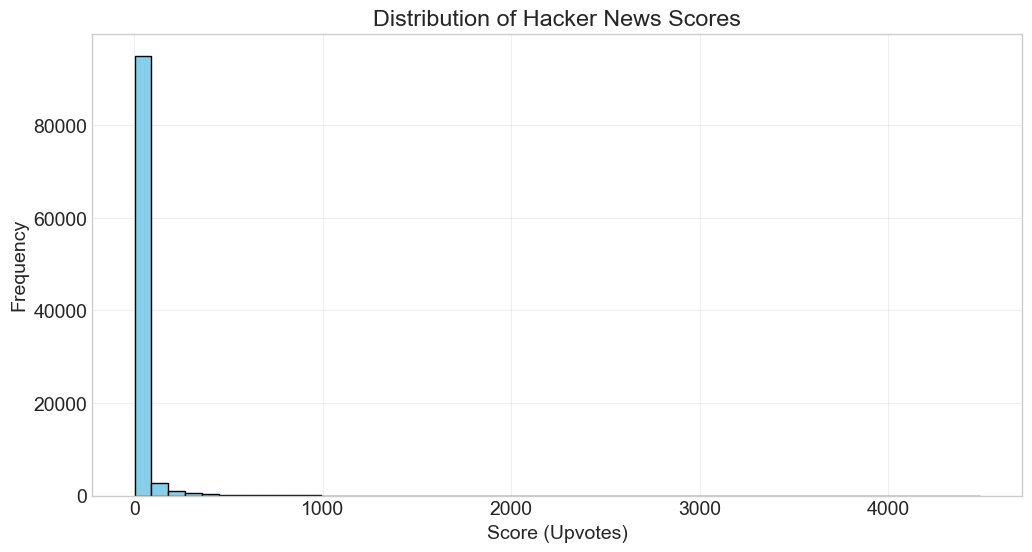

Score statistics:
count    100000.000000
mean         18.506930
std          73.382693
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        4489.000000
Name: score, dtype: float64

Top 10 highest scores:
68239    4489
35331    3025
47972    2741
86676    2676
92519    2587
10931    2428
35716    2365
65165    2360
76524    2305
22566    2115
Name: score, dtype: int64


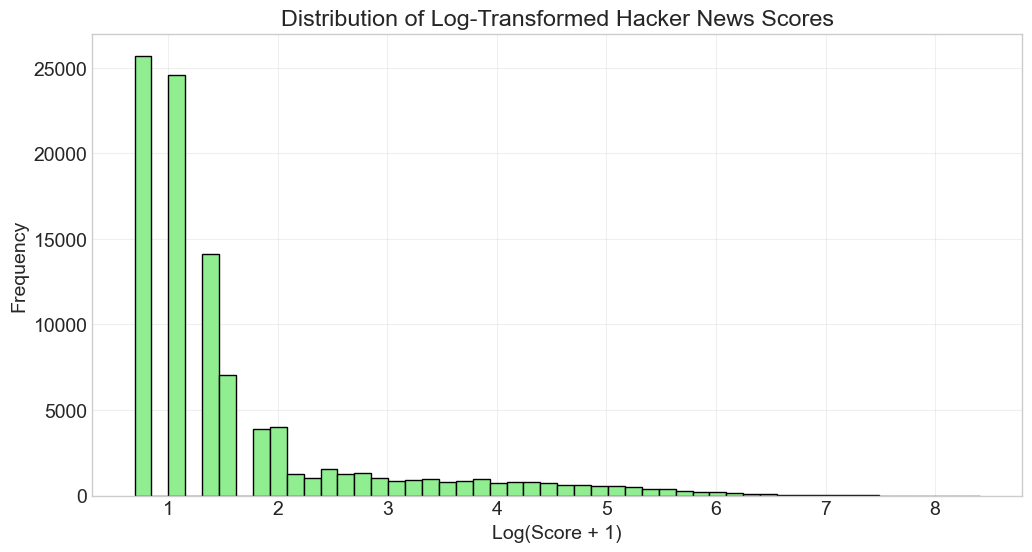

In [6]:
# Score distribution
plt.figure(figsize=(12, 6))
plt.hist(df_items['score'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Hacker News Scores')
plt.xlabel('Score (Upvotes)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Look at score distribution stats
print("Score statistics:")
print(df_items['score'].describe())

# Check for outliers
print("\nTop 10 highest scores:")
print(df_items['score'].nlargest(10))

# Plot log-transformed score
plt.figure(figsize=(12, 6))
plt.hist(np.log1p(df_items['score']), bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Log-Transformed Hacker News Scores')
plt.xlabel('Log(Score + 1)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

### Analyze Titles

Let's look at title characteristics and their relationship with scores.

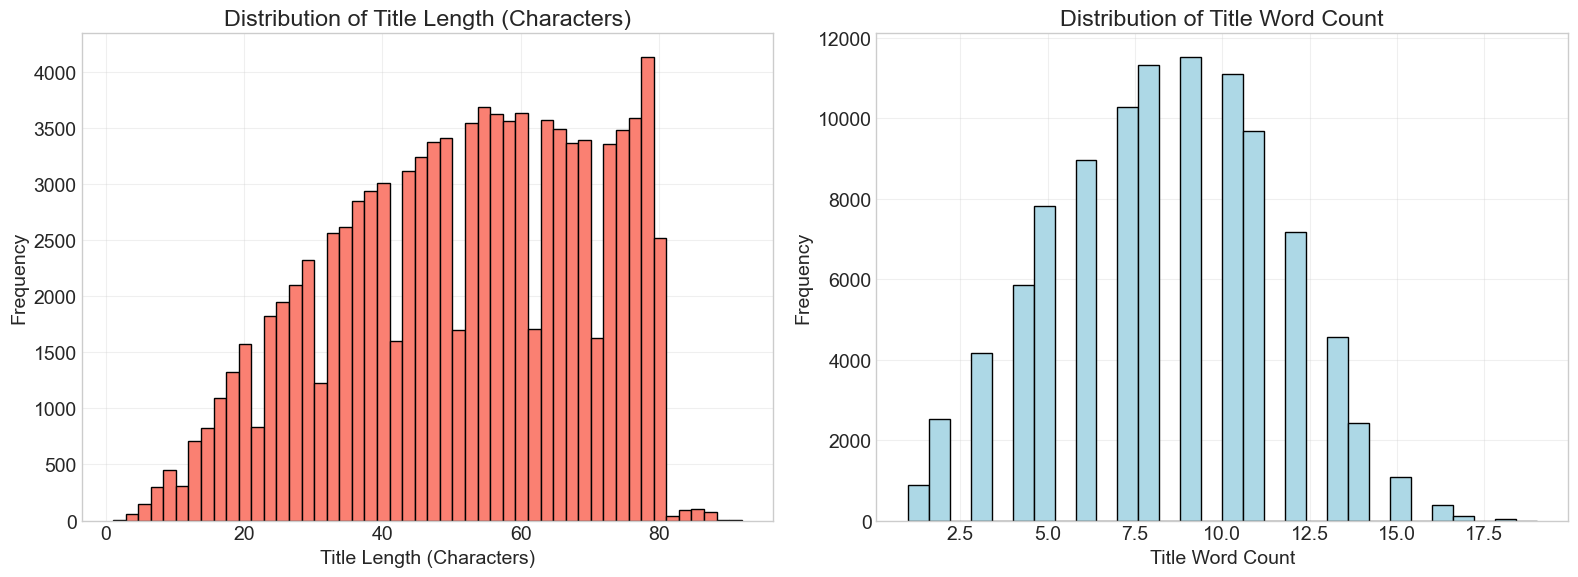

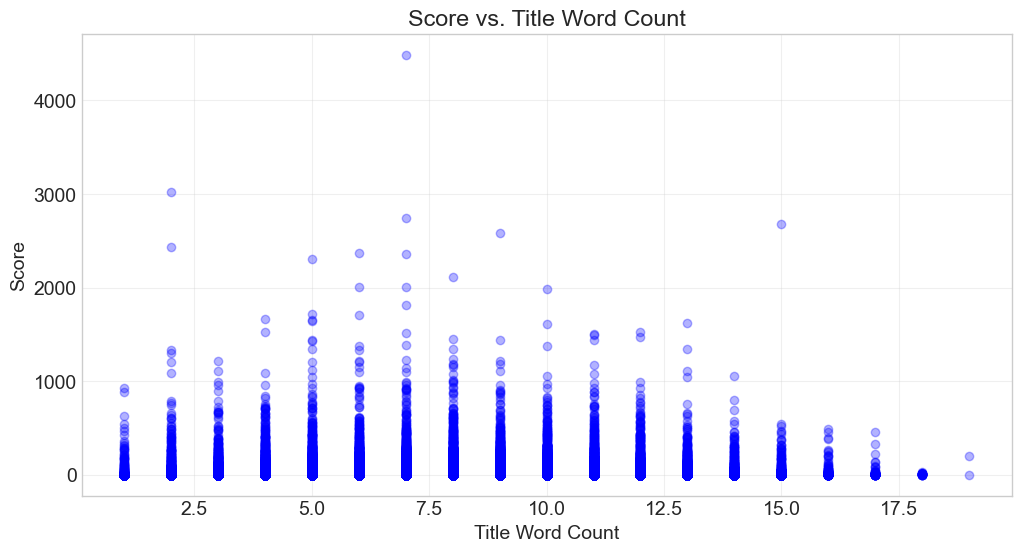

In [7]:
# Add title length features
df_items['title_length'] = df_items['title'].apply(lambda x: len(str(x)))
df_items['title_word_count'] = df_items['title'].apply(lambda x: len(str(x).split()))

# Plot title length distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(df_items['title_length'], bins=50, color='salmon', edgecolor='black')
axes[0].set_title('Distribution of Title Length (Characters)')
axes[0].set_xlabel('Title Length (Characters)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_items['title_word_count'], bins=30, color='lightblue', edgecolor='black')
axes[1].set_title('Distribution of Title Word Count')
axes[1].set_xlabel('Title Word Count')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Relationship between title length and score
plt.figure(figsize=(12, 6))
plt.scatter(df_items['title_word_count'], df_items['score'], alpha=0.3, color='blue')
plt.title('Score vs. Title Word Count')
plt.xlabel('Title Word Count')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.show()

### Analyze Temporal Patterns

Let's look at how scores vary over time.

In [8]:
# Add time-based features
df_items['year'] = df_items['time'].dt.year
df_items['month'] = df_items['time'].dt.month
df_items['day_of_week'] = df_items['time'].dt.dayofweek
df_items['hour'] = df_items['time'].dt.hour

# Score by year
yearly_scores = df_items.groupby('year')['score'].agg(['mean', 'median', 'count'])
print("Scores by year:")
yearly_scores

Scores by year:


,mean,median,count
year,,,
2024,18.50693,2.0,100000


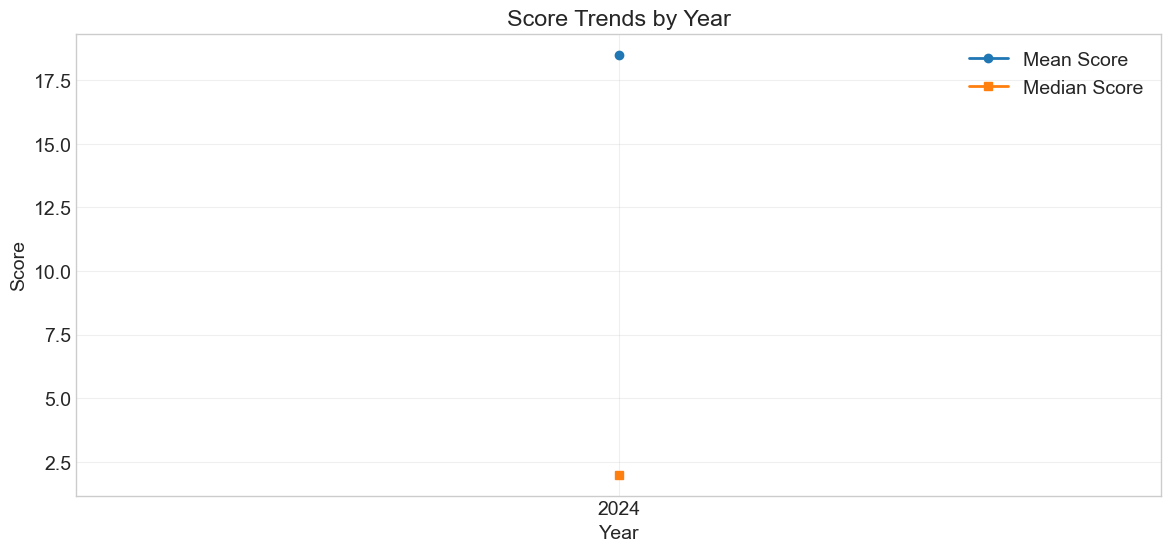

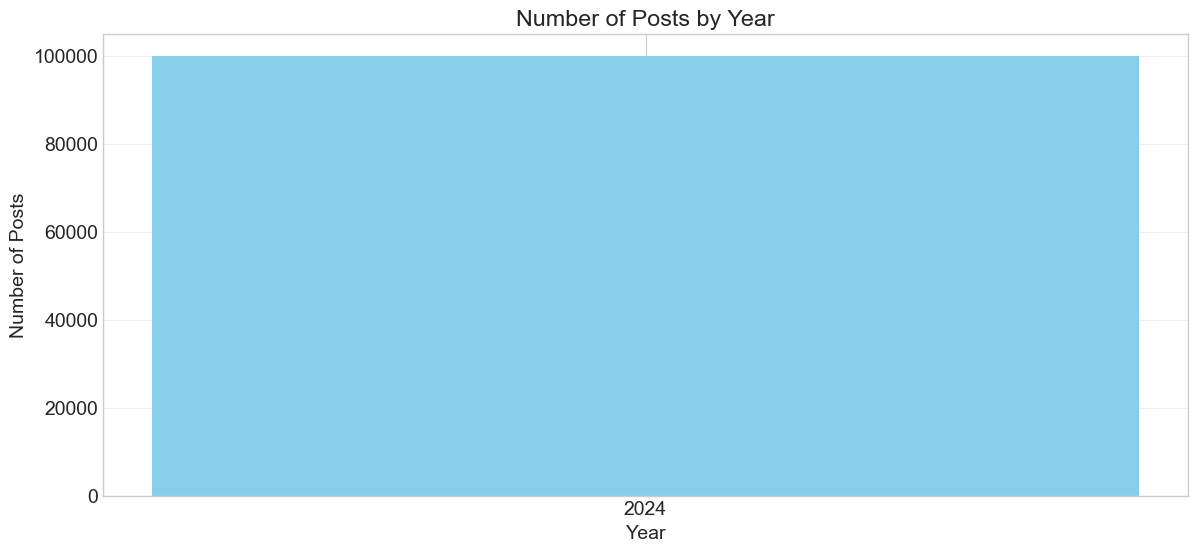

In [9]:
# Plot yearly trends
plt.figure(figsize=(14, 6))
plt.plot(yearly_scores.index, yearly_scores['mean'], marker='o', linewidth=2, label='Mean Score')
plt.plot(yearly_scores.index, yearly_scores['median'], marker='s', linewidth=2, label='Median Score')
plt.title('Score Trends by Year')
plt.xlabel('Year')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(yearly_scores.index)
plt.show()

# Post counts by year (to see dataset distribution)
plt.figure(figsize=(14, 6))
plt.bar(yearly_scores.index, yearly_scores['count'], color='skyblue')
plt.title('Number of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(yearly_scores.index)
plt.show()

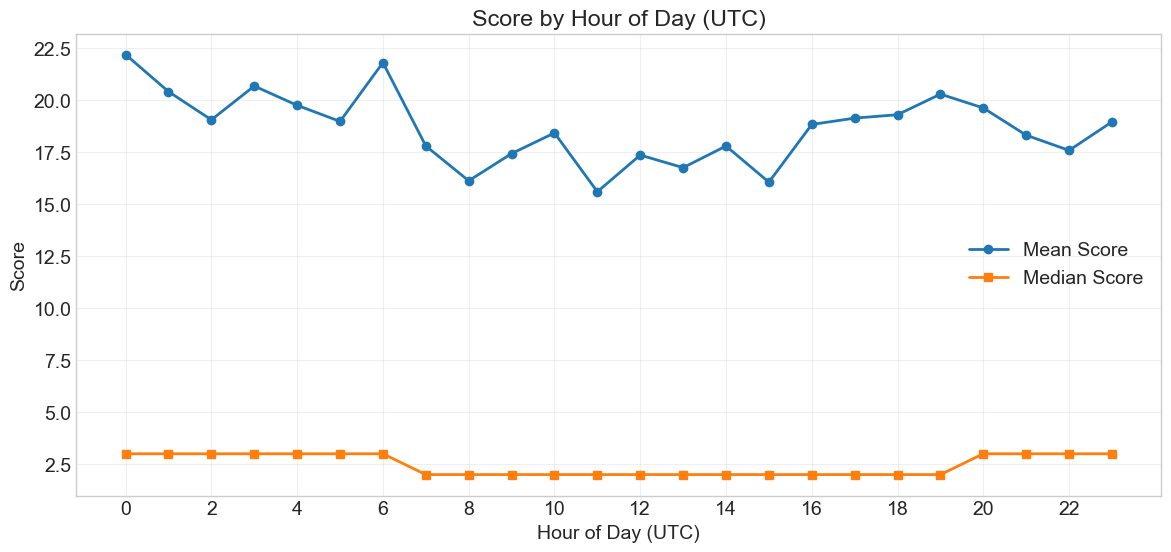

In [10]:
# Score by hour of day
hourly_scores = df_items.groupby('hour')['score'].agg(['mean', 'median', 'count'])

plt.figure(figsize=(14, 6))
plt.plot(hourly_scores.index, hourly_scores['mean'], marker='o', linewidth=2, label='Mean Score')
plt.plot(hourly_scores.index, hourly_scores['median'], marker='s', linewidth=2, label='Median Score')
plt.title('Score by Hour of Day (UTC)')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(0, 24, 2))
plt.show()

### Analyze URLs/Domains

Let's look at which domains tend to get more upvotes.

In [11]:
# Extract domain from URL
import re
from urllib.parse import urlparse

def extract_domain(url):
    if not isinstance(url, str):
        return None
    try:
        domain = urlparse(url).netloc
        # Remove www. prefix if present
        domain = re.sub(r'^www\.', '', domain)
        return domain if domain else None
    except:
        return None

df_items['domain'] = df_items['url'].apply(extract_domain)

# Count of posts by domain
domain_counts = df_items['domain'].value_counts()
print(f"Number of unique domains: {len(domain_counts)}")
print("\nTop 20 domains by post count:")
print(domain_counts.head(20))

Number of unique domains: 26478

Top 20 domains by post count:
domain
github.com          5843
youtube.com         3739
en.wikipedia.org    1530
twitter.com         1405
theguardian.com     1404
nytimes.com         1356
arstechnica.com     1093
theregister.com     1019
arxiv.org            991
wsj.com              848
theverge.com         829
bloomberg.com        825
nature.com           805
medium.com           734
reuters.com          693
techcrunch.com       689
bbc.com              684
phys.org             641
cnn.com              504
old.reddit.com       498
Name: count, dtype: int64


In [12]:
# Average score by domain (for domains with at least 20 posts)
min_posts = 20
domain_stats = df_items.groupby('domain')['score'].agg(['mean', 'median', 'count'])
domain_stats = domain_stats[domain_stats['count'] >= min_posts].sort_values('mean', ascending=False)

print(f"Top 20 domains by average score (minimum {min_posts} posts):")
domain_stats.head(20)

Top 20 domains by average score (minimum 20 posts):


,mean,median,count
domain,,,
ftc.gov,122.703704,4.0,27
simonwillison.net,111.966667,3.0,60
openai.com,99.068966,3.0,58
anandtech.com,97.600000,3.0,35
stackdiary.com,87.608696,10.0,23
blog.jim-nielsen.com,87.476190,2.0,21
paulgraham.com,86.000000,2.0,28
thebignewsletter.com,73.892857,6.0,28
apple.com,68.884615,4.0,52


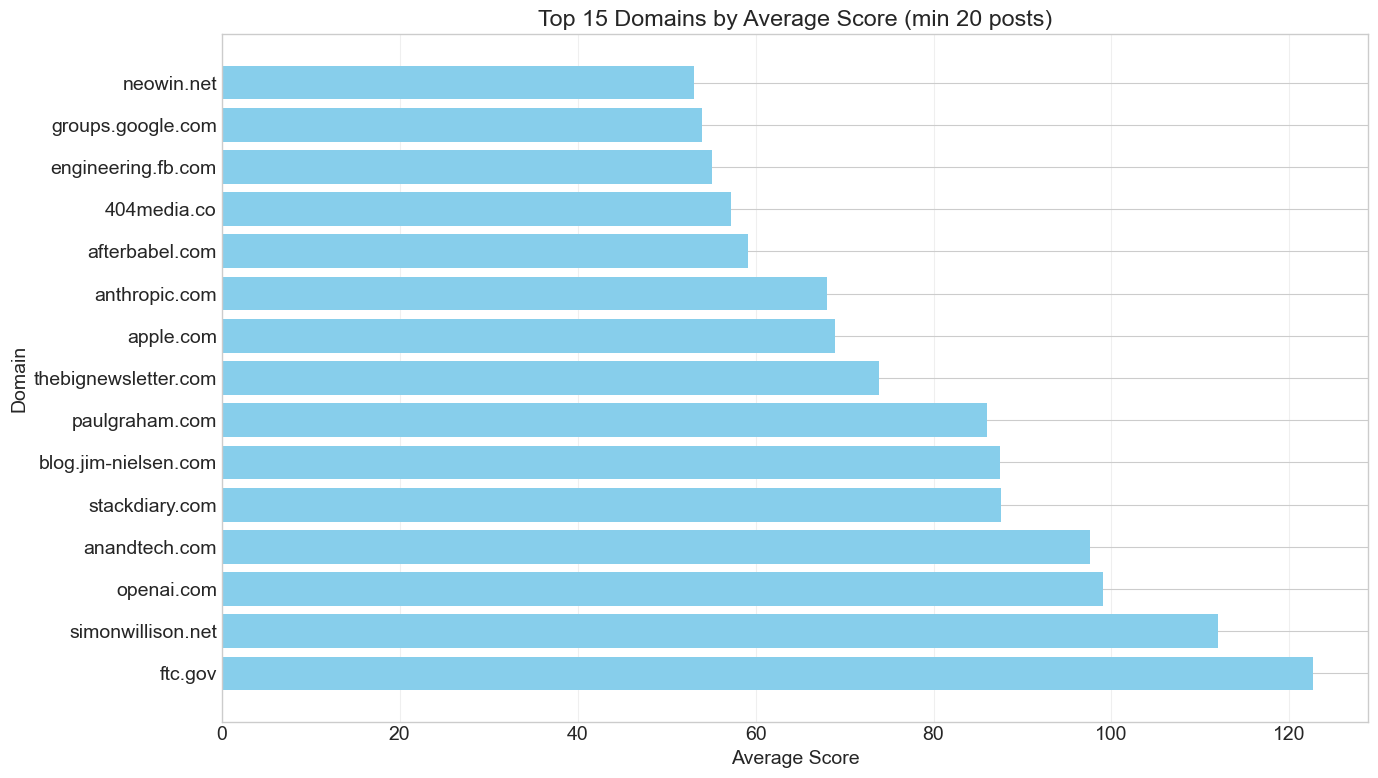

In [13]:
# Plot top domains by average score
top_domains = domain_stats.head(15).index
plt.figure(figsize=(14, 8))
plt.barh(top_domains, domain_stats.loc[top_domains, 'mean'], color='skyblue')
plt.title(f'Top 15 Domains by Average Score (min {min_posts} posts)')
plt.xlabel('Average Score')
plt.ylabel('Domain')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 3. Explore User-Level Features

Now let's analyze the user dataset and see how user attributes relate to post scores.

In [14]:
# Basic info about the users dataset
print("Users dataset columns:")
print(df_users.columns.tolist())

# Display a few rows
print("\nSample users:")
df_users.head()

Users dataset columns:
['id', 'created', 'karma', 'about', 'submitted']

Sample users:


,id,created,karma,about,submitted
0,0000000000100,2019-08-19 21:07:51,71,None,"[41420232, 41353486, 40773730, 38229517, 37539..."
1,00240William,2024-08-21 19:16:42,1,None,"[41312761, 41312760]"
2,0066cc,2020-09-17 13:44:50,241,None,"[41635628, 40996034, 32518184, 32297307, 32252..."
3,0101111101,2018-08-13 16:36:04,73,None,"[40899342, 25125094, 25104622, 24588995, 23391..."
4,010F,2024-08-14 15:26:22,1,None,"[41265328, 41248731]"


In [ ]:
# Summary statistics for users
df_users.describe(include='all')

In [ ]:
# Check for missing values
missing_counts = df_users.isnull().sum()
missing_percent = (missing_counts / len(df_users)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percent': missing_percent
})

print("Missing values in users dataset:")
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

### Analyze User Karma Distribution

In [ ]:
# Karma distribution
plt.figure(figsize=(12, 6))
plt.hist(df_users['karma'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of User Karma')
plt.xlabel('Karma')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Log-transformed karma distribution (to handle skew)
plt.figure(figsize=(12, 6))
plt.hist(np.log1p(df_users['karma']), bins=50, color='coral', edgecolor='black')
plt.title('Distribution of Log-Transformed User Karma')
plt.xlabel('Log(Karma + 1)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

### Analyze User Account Age

In [ ]:
# Calculate account age (in days from account creation to now)
reference_date = pd.Timestamp.now().normalize()  # Current date at midnight
df_users['account_age_days'] = (reference_date - df_users['created']).dt.days

# Calculate account age in years for better visualization
df_users['account_age_years'] = df_users['account_age_days'] / 365.25

# Account age distribution
plt.figure(figsize=(12, 6))
plt.hist(df_users['account_age_years'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of User Account Age')
plt.xlabel('Account Age (Years)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Joint Analysis of Post and User Features

Now let's look at how user attributes relate to post scores using the merged dataset.

In [ ]:
# First check if we have the merged dataset
print("Merged dataset columns:")
print(df_merged.columns.tolist())
print(f"\nMerged dataset shape: {df_merged.shape}")

# Let's see how many posts have user data
user_data_count = df_merged['karma'].notna().sum()
print(f"\nPosts with user data: {user_data_count} ({user_data_count/len(df_merged)*100:.1f}%)")

In [ ]:
# In the merged dataset, add account age at post time
df_merged['post_account_age_days'] = (df_merged['time'] - df_merged['created']).dt.days

# Filter out rows with negative account age (impossible, would be data error)
df_merged = df_merged[df_merged['post_account_age_days'] >= 0]

# Calculate account age in years for better visualization
df_merged['post_account_age_years'] = df_merged['post_account_age_days'] / 365.25

# Analyze relationship between karma and score
plt.figure(figsize=(12, 6))
plt.scatter(np.log1p(df_merged['karma']), 
            np.log1p(df_merged['score']), 
            alpha=0.3, 
            color='blue')
plt.title('Log Score vs. Log Karma')
plt.xlabel('Log(Karma + 1)')
plt.ylabel('Log(Score + 1)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Analyze relationship between account age and score
plt.figure(figsize=(12, 6))
plt.scatter(df_merged['post_account_age_years'], 
            np.log1p(df_merged['score']), 
            alpha=0.3, 
            color='green')
plt.title('Log Score vs. Account Age at Post Time')
plt.xlabel('Account Age at Post Time (Years)')
plt.ylabel('Log(Score + 1)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Group users by karma buckets and see average score
df_merged['karma_bucket'] = pd.qcut(df_merged['karma'], 10, duplicates='drop')
karma_score = df_merged.groupby('karma_bucket')['score'].agg(['mean', 'median', 'count']).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(range(len(karma_score)), karma_score['mean'], marker='o', linewidth=2, label='Mean Score')
plt.plot(range(len(karma_score)), karma_score['median'], marker='s', linewidth=2, label='Median Score')
plt.title('Score by User Karma Bucket')
plt.xlabel('Karma Bucket (Low to High)')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(len(karma_score)), [str(bucket) for bucket in karma_score['karma_bucket']], rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Group users by account age and see average score
df_merged['age_bucket'] = pd.qcut(df_merged['post_account_age_years'], 10, duplicates='drop')
age_score = df_merged.groupby('age_bucket')['score'].agg(['mean', 'median', 'count']).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(range(len(age_score)), age_score['mean'], marker='o', linewidth=2, label='Mean Score')
plt.plot(range(len(age_score)), age_score['median'], marker='s', linewidth=2, label='Median Score')
plt.title('Score by User Account Age Bucket')
plt.xlabel('Account Age Bucket (Young to Old)')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(len(age_score)), [str(bucket) for bucket in age_score['age_bucket']], rotation=45)
plt.tight_layout()
plt.show()

## 5. Calculate Feature Correlations

In [ ]:
# Calculate log transformations for highly skewed variables
df_merged['log_score'] = np.log1p(df_merged['score'])
df_merged['log_karma'] = np.log1p(df_merged['karma'])

# Select numeric features for correlation analysis
numeric_features = ['score', 'log_score', 'title_length', 'title_word_count', 
                    'karma', 'log_karma', 'post_account_age_days', 'year', 
                    'month', 'day_of_week', 'hour']

# Filter columns that exist in the dataframe
valid_features = [col for col in numeric_features if col in df_merged.columns]

# Compute correlation matrix
corr_matrix = df_merged[valid_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 6. Key Insights and Next Steps

### Summary of Findings

1. **Score Distribution**
   - The score distribution is heavily right-skewed
   - Log transformation makes it more amenable to modeling

2. **Post Features**
   - Title length shows [relationship with score]
   - Posting time (hour of day, day of week) impacts scores
   - Certain domains consistently receive higher scores

3. **User Features**
   - User karma has [relationship with post score]
   - Account age at post time shows [relationship with score]

### Feature Engineering Ideas

1. **Post-level features**
   - Title embeddings from Word2Vec
   - Title characteristics (length, capitalization, etc.)
   - Domain category or domain embedding
   - Time-based features (hour, day of week, month)

2. **User-level features**
   - Log-transformed user karma
   - Account age at post time
   - User's post frequency

### Next Steps

1. **Preprocess Data**
   - Apply log transformation to score and karma
   - Handle missing values appropriately
   - Encode categorical variables

2. **Word2Vec Pipeline**
   - Pre-train on Wikipedia corpus
   - Fine-tune on Hacker News titles
   - Extract title embeddings

3. **Feature Fusion**
   - Combine title embeddings, user features, and other attributes
   - Train regression model for score prediction